In [1]:
""" Import Package """
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.decomposition import PCA
import os
import random
from tqdm import tqdm
import wandb
from sklearn.preprocessing import PolynomialFeatures
import time
import copy
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import _LRScheduler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

""" Global variables """
DATA = "./data"
TRAIN_DATA_PATH = f"{DATA}/training.csv"
TEST_DATA_PATH = f"{DATA}/test.csv"
OUTPUT_PREDICTION = f"{DATA}/neural_network_predictions.csv"

First, we want to find the relationthips among the features in the dataset in order to help us decide how to utilize the combination of features.

In [2]:
""" Visualize the relationships among features """
'''train_dataset = pd.read_csv(TRAIN_DATA_PATH)

features = train_dataset[['query_length', 'is_homepage', 'sig1', 'sig2', 
                          'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']]
sns.pairplot(features)
plt.show()'''

"train_dataset = pd.read_csv(TRAIN_DATA_PATH)\n\nfeatures = train_dataset[['query_length', 'is_homepage', 'sig1', 'sig2', \n                          'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']]\nsns.pairplot(features)\nplt.show()"

In [3]:
""" Load dataset """
class SearchEngineDataLoader(Dataset):
    def __init__(self, file_path: str, train: bool, features: list):
        self.data = pd.read_csv(file_path)
        self.features = self.data[features].values
        if train:
            self.labels = self.data['relevance'].values
        else:
            self.labels = None
        
        self.features = self.data[features].values
    
    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.float32).unsqueeze(0)
            return features, label
        else:
            return features


def get_dataset(train_file_path: str,
                test_file_path: str,
                features: list):
    """ Create Dataset """
    train_dataset = SearchEngineDataLoader(train_file_path,
                                           train=True,
                                           features=features)
    test_dataset = SearchEngineDataLoader(test_file_path,
                                          train=False,
                                          features=features)
    return train_dataset, test_dataset


def get_dataloader(train_dataset: SearchEngineDataLoader,
                   test_dataset: SearchEngineDataLoader,
                   batch_size: int, 
                   val_proportion: float = 0,
                   pin_memory: bool = True,
                   shuffle: bool = True,
                   seed: int = 1) -> tuple[DataLoader, DataLoader, int, int]:
    """ Create Dataloader and return in_channels and num_classes """
    in_channels = train_dataset.features.shape[1]
    num_classes = 1  # Assuming binary classification

    # Split into train and validation sets if val_proportion > 0
    if val_proportion > 0:
        val_size = int(len(train_dataset) * val_proportion)
        train_size = len(train_dataset) - val_size
        generator = torch.Generator().manual_seed(seed)
        train_dataset, val_dataset = random_split(train_dataset, 
                                                  [train_size, val_size], 
                                                  generator=generator)
    else:
        train_dataset = train_dataset
        val_dataset = None
    
    # Create DataLoaders
    train_loader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=shuffle, 
                              num_workers=0, 
                              pin_memory=pin_memory)
    
    if val_dataset is not None:
        val_loader = DataLoader(val_dataset, 
                                batch_size=batch_size, 
                                shuffle=False, 
                                num_workers=0, 
                                pin_memory=pin_memory)
    else:
        val_loader = None
    
    test_loader = DataLoader(test_dataset, 
                             batch_size=batch_size, 
                             shuffle=False, 
                             num_workers=0, 
                             pin_memory=pin_memory)

    return train_loader, val_loader, test_loader, in_channels, num_classes


features = ['query_length', 'is_homepage', 'sig1', 'sig2', 
            'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
batch_size = 1024

train_dataset, test_dataset = get_dataset(TRAIN_DATA_PATH,
                                          TEST_DATA_PATH,
                                          features)

print(train_dataset.features.shape)

(80046, 10)


In [4]:
# standardize both dataset 
scaler = StandardScaler()
train_dataset.features = scaler.fit_transform(train_dataset.features)
test_dataset.features = scaler.transform(test_dataset.features)

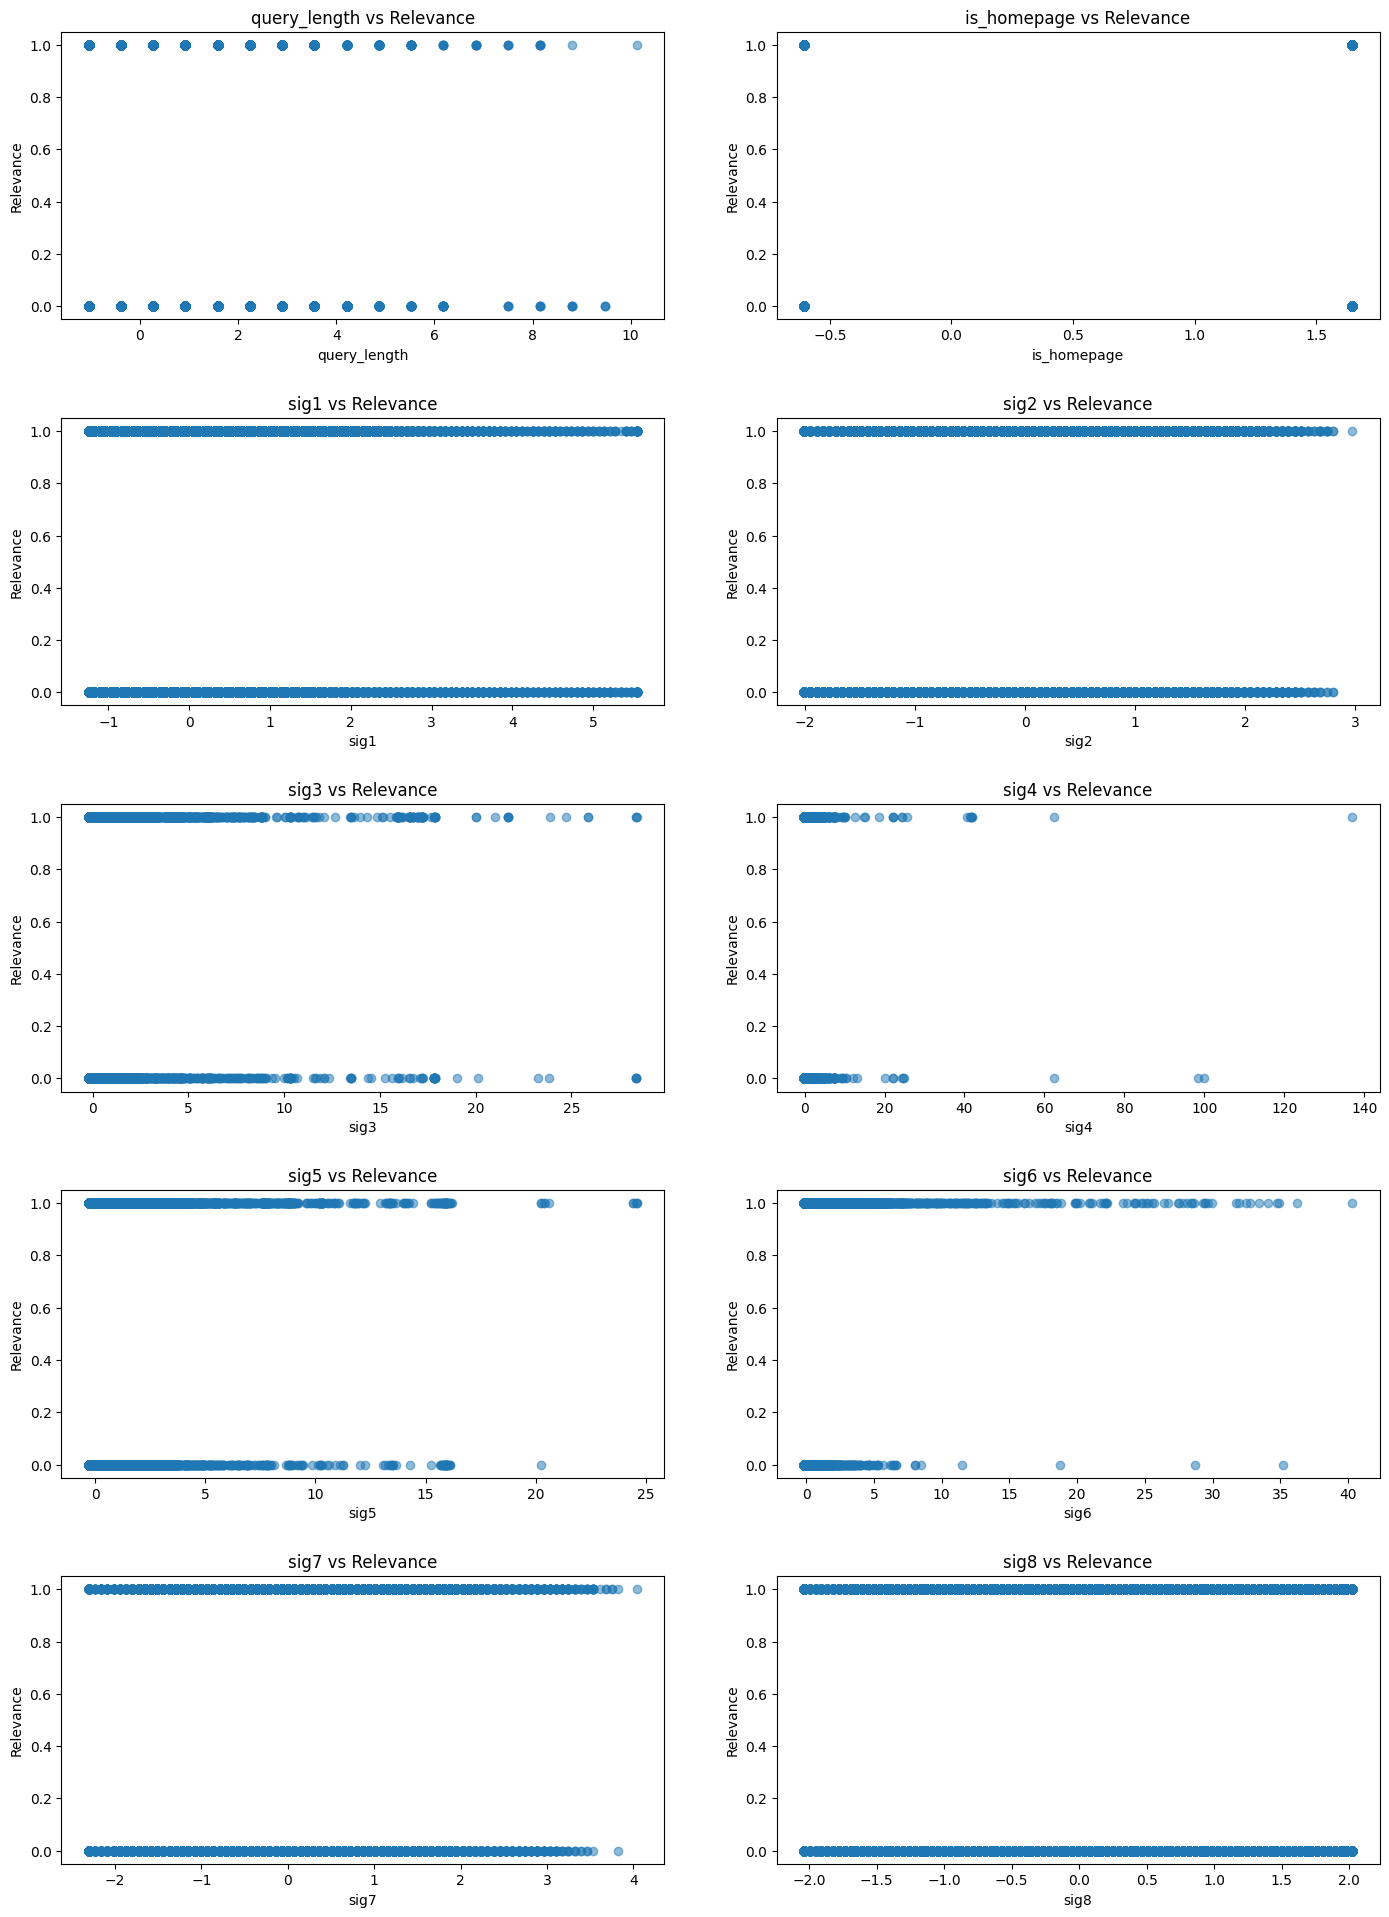

In [5]:
""" Visualize the relationships between features and relevance after preprocessing """
feature_list = ['query_length', 'is_homepage', 'sig1', 'sig2', 
                'sig3', 'sig4', 'sig5', 'sig6', 'sig7', 'sig8']
features = pd.DataFrame(train_dataset.features)
labels = pd.DataFrame(train_dataset.labels)

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 20))
fig.tight_layout(pad=5.0)

for i, column in enumerate(features.columns):
    row, col = divmod(i, 2)
    axes[row, col].scatter(features[column], labels, alpha=0.5)
    axes[row, col].set_title(f'{feature_list[i]} vs Relevance')
    axes[row, col].set_xlabel(feature_list[i])
    axes[row, col].set_ylabel('Relevance')

plt.show()

In [6]:
""" Remove the outlier inside dataset """
'''features_df = pd.DataFrame(train_dataset.features)
Q1 = features_df.quantile(0.25)
Q3 = features_df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

original_sample_num = train_dataset.features.shape[0]

outlier_mask = (features_df < lower_bound) | (features_df > upper_bound)
outlier_count = outlier_mask.sum(axis=1)
outlier_threshold = 5
mask = outlier_count <= outlier_threshold

train_dataset.features = train_dataset.features[mask.values]
train_dataset.labels = train_dataset.labels[mask.values]
washed_sample_num = train_dataset.features.shape[0]
print(f"We remove {original_sample_num - washed_sample_num} outliers from dataset")
print(f"Currently we have {washed_sample_num} total samples")'''

'features_df = pd.DataFrame(train_dataset.features)\nQ1 = features_df.quantile(0.25)\nQ3 = features_df.quantile(0.75)\nIQR = Q3 - Q1\nlower_bound = Q1 - 1.5 * IQR\nupper_bound = Q3 + 1.5 * IQR\n\noriginal_sample_num = train_dataset.features.shape[0]\n\noutlier_mask = (features_df < lower_bound) | (features_df > upper_bound)\noutlier_count = outlier_mask.sum(axis=1)\noutlier_threshold = 5\nmask = outlier_count <= outlier_threshold\n\ntrain_dataset.features = train_dataset.features[mask.values]\ntrain_dataset.labels = train_dataset.labels[mask.values]\nwashed_sample_num = train_dataset.features.shape[0]\nprint(f"We remove {original_sample_num - washed_sample_num} outliers from dataset")\nprint(f"Currently we have {washed_sample_num} total samples")'

In [7]:
""" Apply kernel method to increase features """
'''poly = PolynomialFeatures(degree=3, include_bias=False)
train_dataset.features = poly.fit_transform(train_dataset.features)
test_dataset.features = poly.transform(test_dataset.features)'''

'poly = PolynomialFeatures(degree=3, include_bias=False)\ntrain_dataset.features = poly.fit_transform(train_dataset.features)\ntest_dataset.features = poly.transform(test_dataset.features)'

In [8]:
""" Apply PCA to remove unnecessary features """
'''pca = PCA()
pca.fit(train_dataset.features)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by PCA')
plt.grid(True)
plt.show()

n_components = np.argmax(cumulative_variance_ratio >= 0.9999) + 1
print(f"Number of principal components to retain (99.99% variance): {n_components}")

pca = PCA(n_components=n_components)
train_dataset.features = pca.fit_transform(train_dataset.features)
test_dataset.features = pca.transform(test_dataset.features)'''

'pca = PCA()\npca.fit(train_dataset.features)\nexplained_variance_ratio = pca.explained_variance_ratio_\ncumulative_variance_ratio = np.cumsum(explained_variance_ratio)\n\nplt.figure(figsize=(8, 6))\nplt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker=\'o\', linestyle=\'--\')\nplt.xlabel(\'Number of Principal Components\')\nplt.ylabel(\'Cumulative Explained Variance Ratio\')\nplt.title(\'Cumulative Explained Variance Ratio by PCA\')\nplt.grid(True)\nplt.show()\n\nn_components = np.argmax(cumulative_variance_ratio >= 0.9999) + 1\nprint(f"Number of principal components to retain (99.99% variance): {n_components}")\n\npca = PCA(n_components=n_components)\ntrain_dataset.features = pca.fit_transform(train_dataset.features)\ntest_dataset.features = pca.transform(test_dataset.features)'

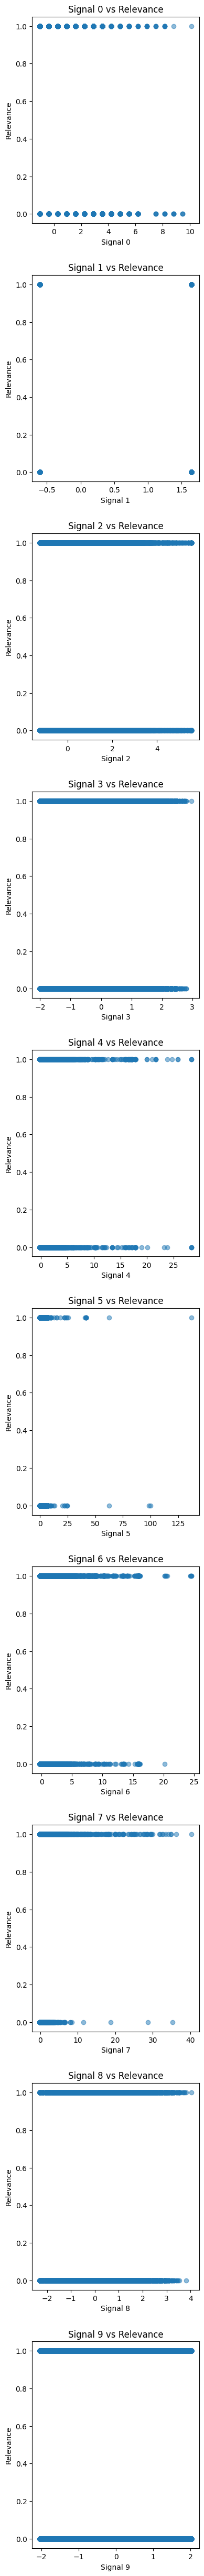

In [9]:
""" Visualize the relationships between features and relevance after preprocessing """
features = pd.DataFrame(train_dataset.features)
labels = pd.DataFrame(train_dataset.labels)
if features.shape[1] < 20:
    fig, axes = plt.subplots(nrows=features.shape[1], figsize=(5, 5 * features.shape[1]))
    fig.tight_layout(pad=5.0)

    for i, column in enumerate(features.columns):
        axes[i].scatter(features[column], labels, alpha=0.5)
        axes[i].set_title(f'Signal {i} vs Relevance')
        axes[i].set_xlabel(f"Signal {i}")
        axes[i].set_ylabel('Relevance')

    plt.show()

In [10]:
""" Get Dataloader """
train_loader, val_loader, test_loader, in_channels, num_class = get_dataloader(train_dataset=train_dataset,
                                                                               test_dataset=test_dataset,
                                                                               batch_size=batch_size,
                                                                               val_proportion=0.1,
                                                                               pin_memory=True,
                                                                               shuffle=True,
                                                                               seed=1,)
print(f"Sample numbers: {train_dataset.features.shape[0]}")
print(f"Feature numbers: {train_dataset.features.shape[1]}")

Sample numbers: 80046
Feature numbers: 10


In [11]:
""" Modeling using Neural Network """
def torch_set_random_seed(seed: int = 1) -> None:
    """ Set random seed for reproducible usage """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


class WarmUpLR(_LRScheduler):
    # The fuction is adapted from https://github.com/weiaicunzai/pytorch-cifar100/blob/master/utils.py
    # author: baiyu
    """ Warmup_training learning rate scheduler """
    def __init__(self, optimizer, total_iters, last_epoch=-1):

        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """ Fpr first m batches, and set the learning rate to base_lr * m / total_iters """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]


def train(model: nn.Module, 
          train_loader: DataLoader, 
          loss_function: nn.Module,
          optimizer: optim.Optimizer,
          lr_scheduler_warmup: WarmUpLR,
          warm: int,
          epoch: int,
          device: str) -> float:
    """ Train model and save using early stop on test dataset """
    model.train()
    train_loss = 0.0
    for features, labels in train_loader:
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if epoch <= warm:
            lr_scheduler_warmup.step()

    train_loss /= len(train_loader)
    return train_loss


@torch.no_grad()
def evaluate(model: nn.Module,
             eval_loader: DataLoader, 
             loss_function: nn.Module, 
             threshold: float,
             device: str) -> tuple[float, float]:
    """ Evaluate model """
    model.eval()
    correct = 0.0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for features, labels in eval_loader:
            features = features.to(device)
            labels = labels.to(device)

            outputs = model(features)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()
            
            predicted = (torch.sigmoid(outputs) > threshold).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    average_loss = total_loss / len(eval_loader)
    return accuracy, average_loss


""" Train model on dataloader """
model_name = "resnet18"
total_epoch = 50
initial_lr = 0
min_lr = 0
random_seed = 1
split_seed = 1
warm = 1

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Running on device: {device}")

output_dir = "output_models"
overall_best_acc = 0
optimal_initial_lr = 0
optimal_min_lr = 0

for threshold in [0.5]:
    for initial_lr in [1e-1]:
        for min_lr in [1e-3]:
            best_acc = 0.0
            for split_seed in [1, 10, 100]:
                torch_set_random_seed(random_seed)
                hyperparams_config = {
                    "model": model_name,
                    "epoch": total_epoch,
                    "initial_lr": initial_lr,
                    "min_lr": min_lr,
                    "random_seed": random_seed
                }
                wandb.init(
                    project=f"STATS-Project-new-{model_name}",
                    name=f"{int(time.time())}",
                    id=str(int(time.time())),
                    config=hyperparams_config,
                    mode='online'
                )
                train_loader, val_loader, test_loader, in_channels, num_class = get_dataloader(train_dataset=train_dataset,
                                                                                                test_dataset=test_dataset,
                                                                                                batch_size=batch_size,
                                                                                                val_proportion=0.375,
                                                                                                pin_memory=True,
                                                                                                shuffle=True,
                                                                                                seed=split_seed,)
                from resnet import resnet18, resnet34, resnet50, resnet101, resnet152
                from vgg import vgg11, vgg13, vgg16, vgg19
                from lenet import Lenet5
                model = resnet18(in_channels, num_class).to(device)

                loss_function = nn.BCEWithLogitsLoss()
                optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=1e-2)
                lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                                    T_max=total_epoch - 5 - warm, 
                                                                    eta_min= min_lr,
                                                                    last_epoch=-1)
                iter_per_epoch = len(train_loader)
                lr_scheduler_warmup = WarmUpLR(optimizer, iter_per_epoch * warm)

                cur_best_acc = 0
                with tqdm(total=total_epoch, desc=f'Training', unit='epoch') as pbar:
                    for epoch in range(1, total_epoch + 1):
                        train_loss = train(model, 
                                            train_loader, 
                                            loss_function, 
                                            optimizer, 
                                            lr_scheduler_warmup,
                                            warm,
                                            epoch,
                                            device)
                        top1_acc, eval_loss = evaluate(model, 
                                                    val_loader, 
                                                    loss_function, 
                                                    threshold,
                                                    device)
                        if epoch <= total_epoch - 5 and epoch > warm:
                            lr_scheduler.step()

                        if cur_best_acc < top1_acc:
                            cur_best_acc = top1_acc
                            if best_acc < cur_best_acc:
                                best_acc = cur_best_acc
                                os.makedirs(f"{output_dir}", exist_ok=True)
                                output_pth = f"{output_dir}/best_model.pth"
                                print(f"Best model stored to {output_pth}")
                                torch.save(model, output_pth)
                        
                        for param_group in optimizer.param_groups:
                            lr = param_group['lr']
                        
                        wandb.log({"epoch": epoch, "train_loss": train_loss, 'lr': lr,
                                   "top1_acc": top1_acc, "eval_loss": eval_loss, 'threshold': threshold,
                                   "best top1 acc": cur_best_acc})
                        
                        pbar.set_postfix({'Train loss': train_loss, 'overall_best_acc': overall_best_acc, 'Best top1 acc': cur_best_acc, 'Top1 acc': top1_acc})
                        pbar.update(1)
                
                wandb.finish()
                print(f"Seed {split_seed} has best_acc: {cur_best_acc}")
                overall_best_acc += cur_best_acc

print(overall_best_acc / 3)
print(best_acc)
print(optimal_initial_lr)
print(optimal_min_lr)
print(total_epoch)


Running on device: cuda


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: wangboyao-02 (beryex). Use `wandb login --relogin` to force relogin


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

Best model stored to output_models/best_model.pth


Training:   2%|▏         | 1/50 [00:00<00:46,  1.04epoch/s, Train loss=0.681, overall_best_acc=0, Best top1 acc=0.606, Top1 acc=0.606]

Best model stored to output_models/best_model.pth


Training:   8%|▊         | 4/50 [00:03<00:40,  1.14epoch/s, Train loss=0.62, overall_best_acc=0, Best top1 acc=0.611, Top1 acc=0.609] 

Best model stored to output_models/best_model.pth


Training:  10%|█         | 5/50 [00:04<00:39,  1.14epoch/s, Train loss=0.619, overall_best_acc=0, Best top1 acc=0.622, Top1 acc=0.622]

Best model stored to output_models/best_model.pth


Training:  12%|█▏        | 6/50 [00:05<00:37,  1.16epoch/s, Train loss=0.621, overall_best_acc=0, Best top1 acc=0.624, Top1 acc=0.624]

Best model stored to output_models/best_model.pth


Training:  14%|█▍        | 7/50 [00:06<00:37,  1.15epoch/s, Train loss=0.619, overall_best_acc=0, Best top1 acc=0.634, Top1 acc=0.634]

Best model stored to output_models/best_model.pth


Training:  16%|█▌        | 8/50 [00:07<00:36,  1.14epoch/s, Train loss=0.618, overall_best_acc=0, Best top1 acc=0.65, Top1 acc=0.65]  

Best model stored to output_models/best_model.pth


Training:  18%|█▊        | 9/50 [00:08<00:37,  1.10epoch/s, Train loss=0.619, overall_best_acc=0, Best top1 acc=0.654, Top1 acc=0.654]

Best model stored to output_models/best_model.pth


Training:  20%|██        | 10/50 [00:08<00:36,  1.09epoch/s, Train loss=0.619, overall_best_acc=0, Best top1 acc=0.656, Top1 acc=0.656]

Best model stored to output_models/best_model.pth


Training:  22%|██▏       | 11/50 [00:10<00:37,  1.04epoch/s, Train loss=0.618, overall_best_acc=0, Best top1 acc=0.656, Top1 acc=0.656]

Best model stored to output_models/best_model.pth


Training:  32%|███▏      | 16/50 [00:15<00:36,  1.06s/epoch, Train loss=0.618, overall_best_acc=0, Best top1 acc=0.659, Top1 acc=0.653]

Best model stored to output_models/best_model.pth


Training:  52%|█████▏    | 26/50 [00:26<00:25,  1.08s/epoch, Train loss=0.615, overall_best_acc=0, Best top1 acc=0.662, Top1 acc=0.66] 

Best model stored to output_models/best_model.pth


Training:  68%|██████▊   | 34/50 [00:35<00:17,  1.08s/epoch, Train loss=0.612, overall_best_acc=0, Best top1 acc=0.663, Top1 acc=0.663]

Best model stored to output_models/best_model.pth


Training:  80%|████████  | 40/50 [00:41<00:10,  1.08s/epoch, Train loss=0.609, overall_best_acc=0, Best top1 acc=0.665, Top1 acc=0.663]

Best model stored to output_models/best_model.pth


Training:  82%|████████▏ | 41/50 [00:42<00:09,  1.08s/epoch, Train loss=0.609, overall_best_acc=0, Best top1 acc=0.666, Top1 acc=0.666]

Best model stored to output_models/best_model.pth


Training:  86%|████████▌ | 43/50 [00:44<00:07,  1.08s/epoch, Train loss=0.608, overall_best_acc=0, Best top1 acc=0.667, Top1 acc=0.666]

Best model stored to output_models/best_model.pth


Training: 100%|██████████| 50/50 [00:52<00:00,  1.05s/epoch, Train loss=0.606, overall_best_acc=0, Best top1 acc=0.668, Top1 acc=0.666]


best top1 acc,▁▂▂▂▃▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_loss,▆██▇▆▄▃▃▂▂▃▃▂▂▃▂▂▂▂▃▂▂▂▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
top1_acc,▁▂▁▂▃▄▆▇▇▇▇▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇████████
train_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best top1 acc,0.66756
epoch,50
eval_loss,0.60574
lr,0.001


Seed 1 has best_acc: 0.6675550521371223


Training: 100%|██████████| 50/50 [00:52<00:00,  1.06s/epoch, Train loss=0.605, overall_best_acc=0.668, Best top1 acc=0.665, Top1 acc=0.664]


best top1 acc,▁▁▁▃▅▅▇▇▇▇▇▇▇▇▇▇▇▇██████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_loss,▆██▆▆▅▃▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
top1_acc,▃▃▁▅▆▄▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇████▇▇███████████
train_loss,█▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
best top1 acc,0.66516
epoch,50
eval_loss,0.60964
lr,0.001


Seed 10 has best_acc: 0.6651564113668921


Training: 100%|██████████| 50/50 [00:53<00:00,  1.07s/epoch, Train loss=0.604, overall_best_acc=1.33, Best top1 acc=0.664, Top1 acc=0.664]


best top1 acc,▁▁▂▃▅▇▇▇▇▇▇▇████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eval_loss,▇█▇▇▅▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
lr,███████▇▇▇▇▇▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
threshold,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
top1_acc,▁▁▂▃▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█▇███▇████████
train_loss,█▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
best top1 acc,0.66412
epoch,50
eval_loss,0.61043
lr,0.001


Seed 100 has best_acc: 0.6641236632574874
0.6656117089205006
0.6675550521371223
0
0
50


In [12]:
""" Predict on test dataset using the best model """
@torch.no_grad()
def predict_and_save_results(model, test_loader, output_file, threshold):
    model.eval() 
    results = []

    with torch.no_grad():
        for idx, features in enumerate(test_loader):
            features = features.to(device)
            outputs = model(features)
            predictions = (torch.sigmoid(outputs) > threshold).float()

            for idx2, prediction in enumerate(predictions):
                sample_id = str(int(test_loader.dataset.data.iloc[idx*batch_size+idx2]['query_id'])) + str(int(test_loader.dataset.data.iloc[idx*batch_size+idx2]['url_id']))
                results.append({'id': sample_id, 'relevance': int(prediction)})

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_file, index=False)

best_model = torch.load(f"{output_dir}/best_model.pth").to(device)
predict_and_save_results(best_model, test_loader, OUTPUT_PREDICTION, threshold)
print(f"Predictions saved at {OUTPUT_PREDICTION}")